# Getting started
___
The following illustrates the basic functionalities of the proteusAI package, such as training machine learning models using experimental data, performing zero-shot predictions and visualizing results. 

## Training models with experimental data
___

### 1.  Loading data from csv files

In [18]:
import sys
sys.path.append('../src/')
import proteusAI as pai

# will initiate storage space - else in memory
library = pai.Library(project='example_project', overwrite=False) 

# load data from csv or excel: x should be sequences, y should be labels, y_type class or num
library.read_data(data='demo_data/GB1_raw.csv', seqs='Sequence', y='Data', y_type='num', names='Description')

# compute and save ESM-2 representations at example_lib/representations/esm2
library.compute(method='esm2')

Library example_project already exists. Loading existing library...
Loading library 'example_project'...
- Found representations of type 'esm2' in 'rep/esm2'.
Loading done!
100.0% of esm2 computed.


### 1.1 Loading data from fasta files

remember to rename the files accordingly when reading the same data with different names to prevent redundant computations. Here the protein names are updated to the names in the csv file instead of the names in the fasta headers.

In [19]:
# read data from fasta files
#library.read_data(data='demo_data/GB1.fasta')

# rename proteins 
#names = []
#for prot in library.proteins:
#    name = prot.name.split('|')[1].replace('_', '+')
#    names.append(name)
    
#library.rename_proteins(names)

# compute and save ESM-2 representations at example_lib/representations/esm2
#library.compute(method='esm2')

### 2. Training models

In [20]:
# Choose model type, random forest, linear regression, svm, ...
model = pai.Model(model_type='rf')

# will save a model and report at models/rf/
model.train(library=library, x='esm2', split='random')

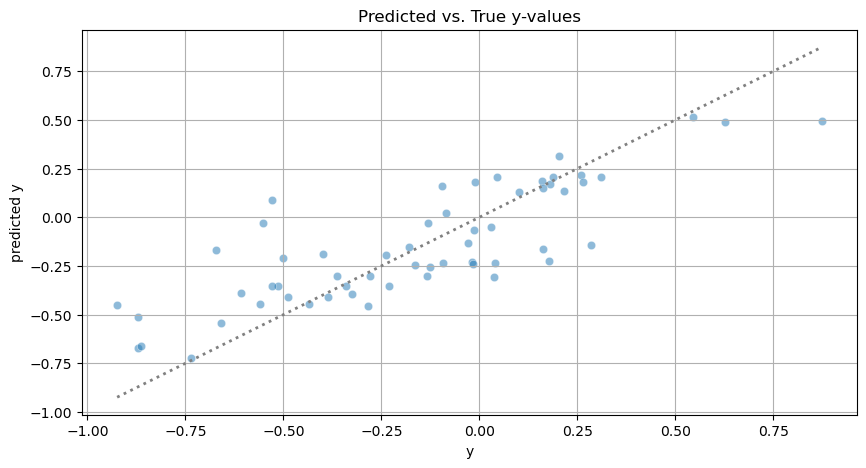

In [21]:
y_t = model.y_val
y_p = model.y_val_pred
model.true_vs_predicted(y_t, y_p, file='val_predicted_vs_true.png')

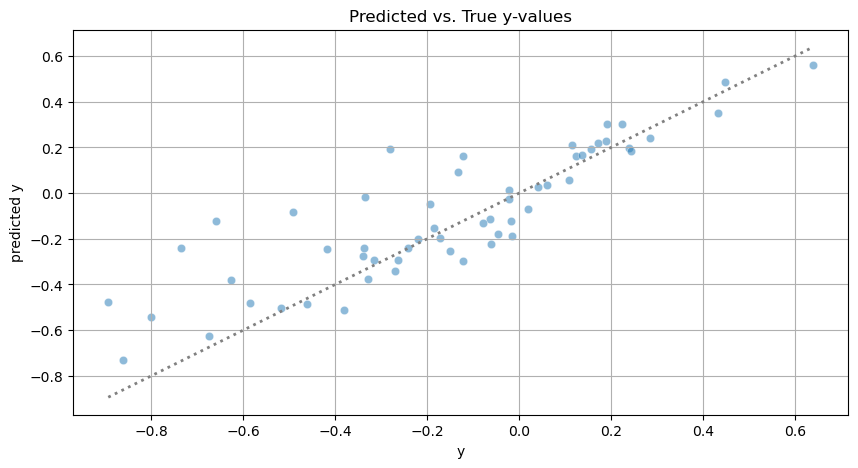

In [22]:
y_t = model.y_test
y_p = model.y_test_pred
model.true_vs_predicted(y_t, y_p)

### 3. Creating model ensembles

In [6]:
#ensemble = pai.Ensemble([model_1, model_2])

### 4. Loading existing libraries and models

In [7]:
# load a library object
#library = pai.Library.load(data='path/to/library')

# load a model object
#model = pai.Model.load(data='path/to/model')

### 5. Making predictions

In [8]:
# load a library object
#library = pai.Library.load(data='path/to/library')

# load a model object
#model = pai.Model.load(data='path/to/model')

### Visualizing library and model results

In [9]:
# create tSNE plot of esm2 representations, colored by class
#library.tsne(x='esm2', fname='path/to/plot/tSNE.png', show=True)

## Making zero-shot predictions
___
### 1. Creating a protein object

In [10]:
# loading a protein from a fasta file
protein = pai.Protein.load_fasta('demo_data/GB1_wt.fasta')
protein

proteusAI.Protein():
____________________
name	: GB1_wt
seq	: MAPTLSEQTRQLVRASVPALQKHSVAISATMYRLLFERYPETRSLCELPERQIHKIASALLAYARSIDNPSALQAAIRRMVLSHARAGVQAVHYPLYWECLRDAIKEVLGPDATETLLQAWKEAYDFLAHLLSTKEAQVYAVLAE
rep	: []
y	None

### 2. Create a library

In [11]:
# create a deep-mutational scanning library
#library = protein.DMS(name='dms')
#library

### Compute scores

In [12]:
# create zero-shot scores using the ESM-2 model and the masked-marginal probability metric
#library.zs_prediction(model='esm2', method='mmp')
#library

In [13]:
# inspect results
#scores = library.zs_scores()
#scores

## Training VAEs
___
### 1. loading MSA

In [14]:
# different formats can be provided 
#msa = pai.Library.load_msa(name='msa', data='msa.fasta')
#msa

### 2. Training a VAE

In [15]:
#vae = pai.Model(type='vae', layers=[2000, 1000, 500], z_dim=200)
#vae = vae.train(lib=msa)

### 3. Use the VAE to create representations

In [16]:
#msa.compute(method='vae', model=vae)

### 4. Finetune VAE

In [17]:
# load library with experimental data
#library = pai.Library.load(data='path/to/library')

# fine tune VAE
#model = pai.Model(lib=library, fine_tune=vae)